In [2]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Unconstrained Optimization



In [13]:
# Import Data 
sp_returns = pd.read_excel("spx_returns_weekly.xlsx", sheet_name=2, index_col = 0)
etf_returns = pd.read_excel("spx_returns_weekly.xlsx", sheet_name=3, index_col = 0)

# Filter Relevant Data
ticks  =  ['AAPL','NVDA','MSFT','GOOGL','AMZN','META','TSLA','AVGO','BRK/B','LLY']
tick_etf = 'SPY'
data = pd.concat([sp_returns[ticks], etf_returns[tick_etf]], axis=1)
data.head()


,AAPL,NVDA,MSFT,GOOGL,AMZN,META,TSLA,AVGO,BRK/B,LLY,SPY
date,,,,,,,,,,,
2015-01-09,0.024514,-0.009315,0.009195,-0.054445,-0.037534,-0.009055,-0.057685,0.047971,0.002011,-0.001855,-0.005744
2015-01-16,-0.053745,0.000836,-0.020131,0.019448,-0.020880,-0.032931,-0.065760,-0.010268,-0.001739,0.010726,-0.012827
2015-01-23,0.065950,0.037578,0.020329,0.061685,0.074431,0.035255,0.042575,0.030500,-0.000603,0.020514,0.016565
2015-01-30,0.036997,-0.072636,-0.143706,-0.008130,0.134900,-0.024669,0.011476,-0.038331,-0.034938,-0.001802,-0.026931
2015-02-06,0.019114,0.062269,0.049753,-0.006812,0.055737,-0.018967,0.067589,0.018037,0.043569,-0.022778,0.030584


## Risk Statistics

### 1.1

In [20]:
# Table with Mean, Volatility, Sharpe Ratio, Skewness, Kurtosis, Max Drawdown 

# Mean, Volatility, Sharpe Ratio, Skewness, Kurtosis
data_mean_ann = data.mean() * 52
data_vol_ann = data.std() * np.sqrt(52)
data_sharpe = data_mean_ann/data_vol_ann
data_skew = data.skew()
data_kurt = data.kurt()

# Max Drawdown 
cum_returns = (1+data).cumprod()
rolling_max = cum_returns.cummax()
drawdown = cum_returns/rolling_max - 1
max_drawdown = drawdown.min() 

# Create table
desc_table = pd.DataFrame({'Mean': data_mean_ann, 
                           'Volatility': data_vol_ann, 
                           'Sharpe_Ratio': data_sharpe, 
                           'Skewness': data_skew, 
                           'Kurtosis': data_kurt, 
                           'Max_Drawdown': max_drawdown})

desc_table.style.format({col: '{:.1%}' for col in desc_table.columns if col not in ['Skewness', 'Kurtosis']})

,Mean,Volatility,Sharpe_Ratio,Skewness,Kurtosis,Max_Drawdown
AAPL,23.9%,27.7%,86.3%,-0.218583,1.825875,-34.6%
NVDA,64.6%,46.3%,139.3%,0.344741,1.389069,-65.9%
MSFT,26.1%,24.0%,108.9%,0.072148,2.341547,-35.1%
GOOGL,21.7%,28.0%,77.5%,0.582916,3.720739,-41.9%
AMZN,29.3%,30.6%,95.9%,0.063289,1.781508,-54.8%
META,26.2%,35.1%,74.6%,0.052425,4.023529,-76.0%
TSLA,47.0%,58.6%,80.1%,0.547533,1.594181,-72.2%
AVGO,39.5%,37.5%,105.3%,0.662112,3.503558,-40.0%
BRK/B,13.5%,19.1%,70.8%,-0.200855,2.513168,-26.5%
LLY,28.2%,28.3%,99.5%,0.216020,1.683187,-25.3%


### 1.2

As a standalone investment, NVDA appears most attractive due to its highest Sharpe ratio and positive skew, which provides exposure to larger upside returns, despite its relatively large historical maximum drawdown of 65.9%. On the other hand, BRK/B is the least attractive in terms of risk-adjusted performance, as it has the lowest Sharpe ratio from the selection of tickers, negative skewness, and moderately high kurtosis, indicating higher exposure to downside tail risk.

### 1.3

In [26]:
from sklearn.linear_model import LinearRegression

# Determine X and Y
X = data['SPY'].values.reshape(-1, 1)

# Table to Store Data
res_table = pd.DataFrame(columns=['Alpha', 'Beta', 'Info Ratio', 'R-Sq'])

# Iterate Through Each Ticker
for ticker in data.columns.drop('SPY'): 
    y = data[ticker].values
    
    model = LinearRegression().fit(X, y)
    alpha = model.intercept_ * 52
    beta = model.coef_[0]

    y_hat = model.predict(X)
    resid = y - y_hat

    info_ratio = alpha / (resid.std() * np.sqrt(52))
    r_sq = model.score(X,y)

    res_table.loc[ticker] = [alpha, beta, info_ratio, r_sq]

res_table.style.format('{:.1%}')


,Alpha,Beta,Info Ratio,R-Sq
AAPL,9.3%,111.3%,46.1%,47.3%
NVDA,41.8%,173.5%,117.5%,41.0%
MSFT,12.6%,103.2%,77.4%,54.0%
GOOGL,7.7%,106.6%,36.2%,42.4%
AMZN,15.3%,106.6%,62.5%,35.5%
META,11.1%,114.8%,38.2%,31.2%
TSLA,23.8%,176.2%,47.4%,26.4%
AVGO,21.7%,135.7%,73.6%,38.2%
BRK/B,2.8%,81.7%,21.4%,53.6%
LLY,19.9%,62.7%,76.2%,14.3%


NVDA stands out again. It has the highest risk and highest information ratio, menaing that its outperformance is large relative to the residual volatility unexplained by SPY.

## 2. Portfolio Allocation

### 2.1

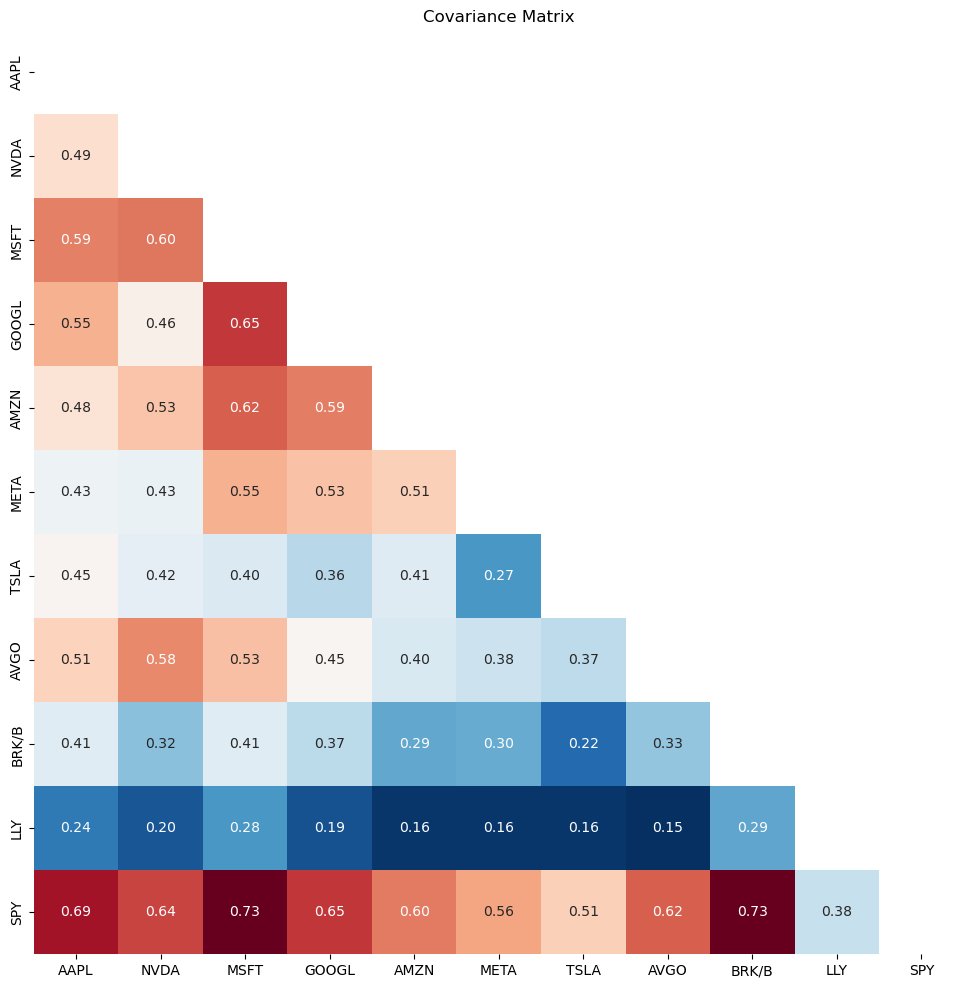

In [43]:
corr = data.corr() 

mask = np.triu(np.ones_like(corr, dtype=bool))
corr[mask] = np.nan

# Plot heatmap 
plt.figure(figsize=(12,12))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', cbar=False)
plt.title("Covariance Matrix")
plt.show()


In [47]:
# Get Max and Min 
corr_pairs = corr.where(np.tril(np.ones(corr.shape), k=1).astype(bool)).stack()
corr_pairs

max = corr_pairs.idxmax(), corr_pairs.max()
min = corr_pairs.idxmin(), corr_pairs.min()

# Print The pais
print(f"Pair with highest correlation: {max[0]} with {max[1]:.4f}")
print(f"Pair with lowest correlation: {min[0]} with {min[1]:.4f}")

Pair with highest correlation: ('SPY', 'MSFT') with 0.7345
Pair with lowest correlation: ('LLY', 'AVGO') with 0.1540


### 2.2

In [69]:
# Covariance matrix
cov_mat = data.cov()

# Weights 
w = np.linalg.inv(cov_mat) @ data.mean()
w_norm = w / w.sum()

res = pd.DataFrame({"Weight": w_norm, "Sharpe": data_sharpe}).round(4)
res

,Weight,Sharpe
AAPL,0.4094,0.8629
NVDA,0.8829,1.3935
MSFT,0.8486,1.0893
GOOGL,0.1931,0.7747
AMZN,0.4264,0.9590
META,0.2774,0.7455
TSLA,0.3101,0.8010
AVGO,0.6019,1.0526
BRK/B,2.5805,0.7082
LLY,1.1126,0.9949


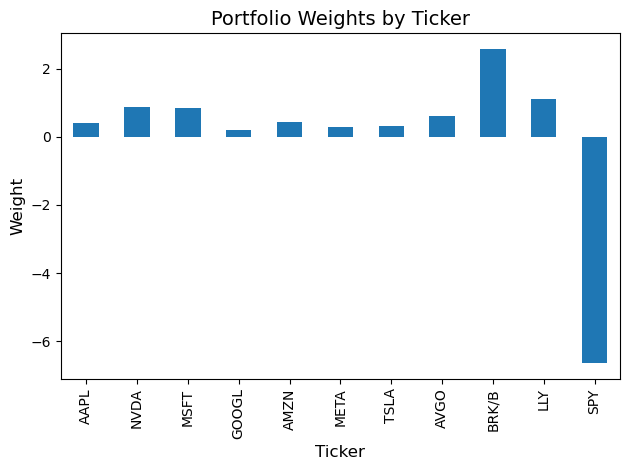

In [70]:
res["Weight"].plot(kind="bar")
plt.title("Portfolio Weights by Ticker", fontsize=14)
plt.xlabel("Ticker", fontsize=12)
plt.ylabel("Weight", fontsize=12)
plt.tight_layout()
plt.show()

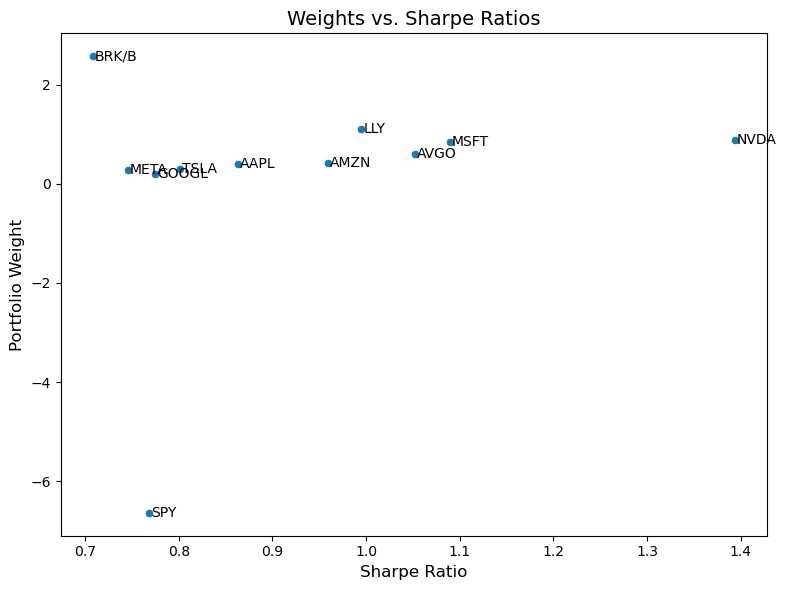

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="Sharpe", y="Weight", data=res)
for i in range(len(res)):
    plt.text(res["Sharpe"].iloc[i] + 0.002,
             res["Weight"].iloc[i], 
             res.index[i],
             fontsize=10, ha='left', va='center')
plt.title("Weights vs. Sharpe Ratios", fontsize=14)
plt.xlabel("Sharpe Ratio", fontsize=12)
plt.ylabel("Portfolio Weight", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
res = res.sort_values(by="Weight", ascending=False).style.format('{:.1%}')
res

,Weight,Sharpe
BRK/B,258.0%,70.8%
LLY,111.3%,99.5%
NVDA,88.3%,139.3%
MSFT,84.9%,108.9%
AVGO,60.2%,105.3%
AMZN,42.6%,95.9%
AAPL,40.9%,86.3%
TSLA,31.0%,80.1%
META,27.7%,74.6%
GOOGL,19.3%,77.5%


### 2.3

In [80]:
# Performance Statistics 
port_mean = (w_norm @ data.mean()) * 52
port_vol = np.sqrt((w_norm @ cov_mat @ w_norm) * 52)
port_sharpe = port_mean/port_vol

# Create a clean DataFrame
perf_table = pd.DataFrame({
    "Portfolio Mean (%)": [port_mean * 100],
    "Portfolio Volatility (%)": [port_vol * 100],
    "Sharpe Ratio": [port_sharpe]
}).round(2)

perf_table

,Portfolio Mean (%),Portfolio Volatility (%),Sharpe Ratio
0,130.22,62.95,2.07


### 2.4


In [82]:
alt_data = data[data.columns.drop("SPY")]

# Covariance matrix
alt_cov_mat = alt_data.cov()

# Weights 
w_alt = np.linalg.inv(alt_cov_mat) @ alt_data.mean()
w_norm_alt = w_alt / w_alt.sum()

res_alt = pd.DataFrame({"Weight": w_norm_alt, "Sharpe": (alt_data.mean() * 52)/(alt_data.std() * (52**0.5))}).round(4)
res_alt


,Weight,Sharpe
AAPL,-0.0545,0.8629
NVDA,0.3279,1.3935
MSFT,0.0738,1.0893
GOOGL,-0.0902,0.7747
AMZN,0.1201,0.9590
META,0.0058,0.7455
TSLA,0.0378,0.8010
AVGO,0.1266,1.0526
BRK/B,0.0448,0.7082
LLY,0.4079,0.9949


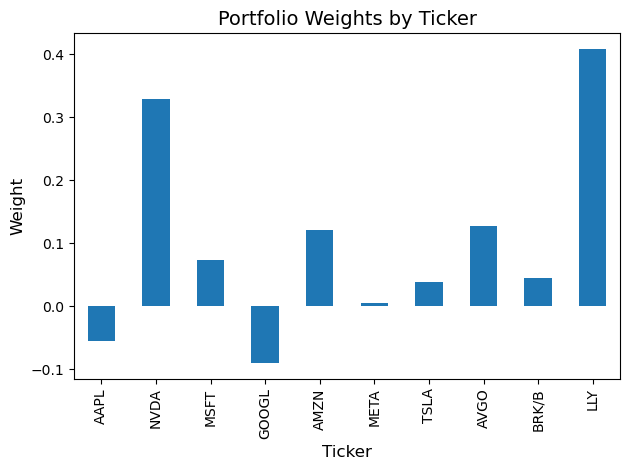

In [83]:
res_alt["Weight"].plot(kind="bar")
plt.title("Portfolio Weights by Ticker", fontsize=14)
plt.xlabel("Ticker", fontsize=12)
plt.ylabel("Weight", fontsize=12)
plt.tight_layout()
plt.show()

The weights after dropping SPY are more reasonable, as we are primarily longing stocks with large weights that also have reasonably high Sharpe ratios and alphas.

When including SPY, we shorted SPY to offset risk associated with its correlation to the tech stocks. Since SPY has a lower mean return than NVDA, we chose to long NVDA, though not by a very large weight (~88%), and offset the position using SPY. We also chose to long BRK/B by a significant amount, given its low volatility and low correlation with other long positions, as well as its ~73% correlation to SPY. By taking a position in the opposite direction of SPY here, we are trying to reduce overall portfolio risk.